In [1]:

import os
import torch
import gc

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()        
    torch.cuda.ipc_collect()


try:
    %run setup_paths
except:
    %run notebooks/setup_paths
    
os.getcwd()

'c:\\Projects\\saliency'

In [2]:
%run src/dataset

isrc = ImagenetSource("imagenet_samples", "*")
all_images = isrc.get_all_images()


(-0.5, 223.5, 223.5, -0.5)

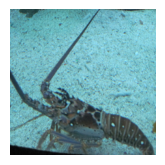

In [3]:
%run src/benchmark
image_name = "ILSVRC2012_val_00012455" ## lobster
#image_name = "ILSVRC2012_val_00000001" ## snake
#image_name = "ILSVRC2012_val_00028649"
image_info = all_images[image_name]
image_path = image_info.path
targetidx = image_info.target
img=Image.open(image_path)
img=img.resize((224,224))  
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')


In [4]:
%run src/benchmark
me = ModelEnv('resnet50')

inp = me.get_image(image_path)
logits = me.model(inp).cpu()
topidx = int(torch.argmax(logits))

print(topidx, targetidx)

C:\Users\zivhd\anaconda3\envs\mcmc\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zivhd\anaconda3\envs\mcmc\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


123 123


In [5]:
sals_dict = {}

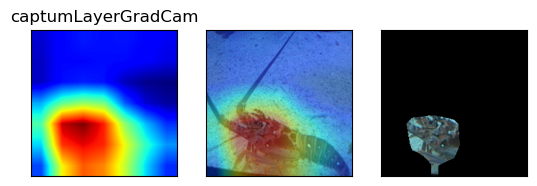

In [11]:

%run src/intutils
%run src/adaptors


algo = CaptumCamSaliencyCreator()
#algo = CamSaliencyCreator(methods=[CMethod.LayerCAM])
res = algo(me, inp, topidx)
list(res.values())[0].shape
show_sal_dict(res, img)
sals_dict.update(res)
## ### torch.Size([32, 1000]) torch.Size([32, 1000, 1]) torch.Size([32, 1]) 123

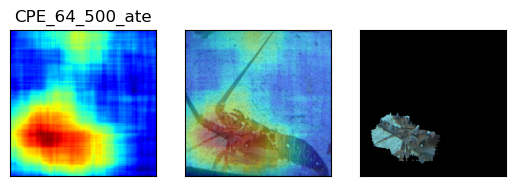

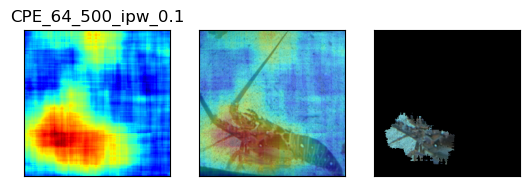

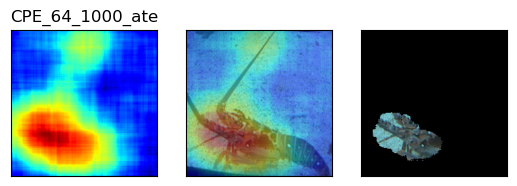

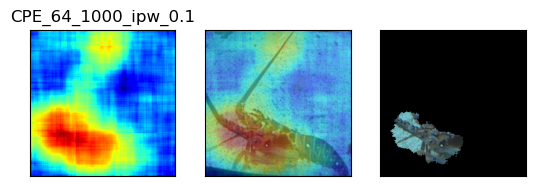

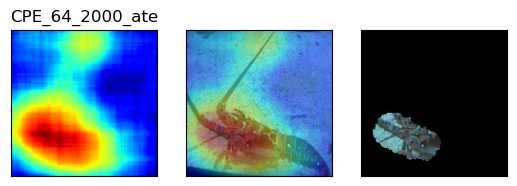

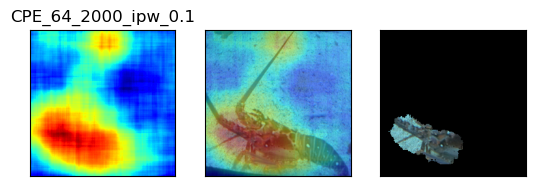

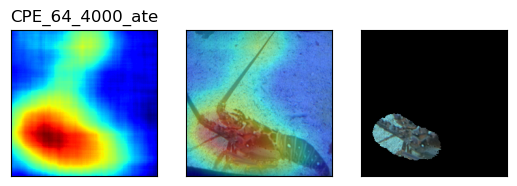

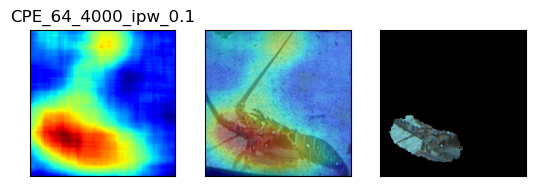

In [6]:

%run src/intutils
%run src/cpe

segsize=64
algo = IpwSalCreator(f"CPE_{segsize}", [500,1000,2000,4000], segsize=segsize, batch_size=32)
res = algo(me, inp, topidx)
show_sal_dict(res, img)
sals_dict.update(res)
## ### torch.Size([32, 1000]) torch.Size([32, 1000, 1]) torch.Size([32, 1]) 123

In [9]:
#torch.Size([32, 2, 1]) torch.Size([32, 2, 1, 1, 1])
#torch.Size([32, 1]) torch.Size([32, 1, 1, 1])

#torch.Size([32, 1]) torch.Size([32, 1, 1, 1])

class AAA:
    bla = 1
aaa = AAA()

getattr(aaa, "bla1", 0)

0

In [ ]:
import captum
dir(captum.attr)

In [ ]:
layer = me.get_cam_target_layer()
guided_gc = captum.attr.LayerGradCam(me.model, layer)

# Perform guided Grad-CAM attribution
cinp = inp.clone().detach() 
cinp.requires_grad_()  # Enable gradients on input
attribution = guided_gc.attribute(cinp, target=topidx)  # Use target class (e.g., class 0)


In [ ]:
attribution.shape
tuple(inp.shape[-2:])


In [3]:
vvv = attribution.squeeze(0).squeeze(0).cpu().detach().numpy()
print(attribution.shape, vvv.shape)
vvv2 = cv2.resize(vvv, (224, 224))
# Visualize the Guided Grad-CAM attribution
plt.imshow(vvv2, cmap='jet')

NameError: name 'attribution' is not defined

In [4]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(me.model)

# Perform Integrated Gradients attribution
cinp = inp.clone().detach() 
cinp.requires_grad_()  # Enable gradients on input

baseline = torch.zeros_like(cinp)  # Use a black image as the baseline

# Compute attributions using Integrated Gradients
attribution = ig.attribute(cinp, baseline, target=topidx, n_steps=100)

# Convert the attribution to numpy
print(attribution.shape)
attribution = attribution.squeeze().cpu().detach().numpy()

# Sum over the color channels (RGB) to get a single grayscale attribution map
attribution = np.sum(attribution, axis=0)
attribution.shape

NameError: name 'me' is not defined

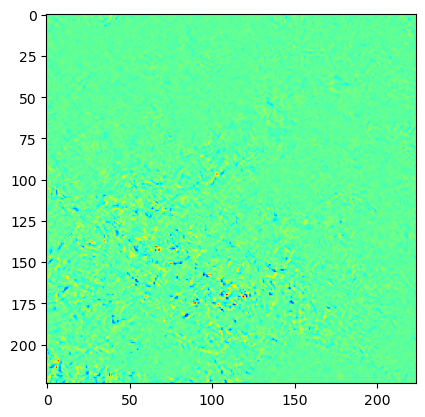

In [167]:
plt.imshow(attribution, cmap='jet')

In [170]:
from captum.attr import GradientShap

# Perform Integrated Gradients attribution
cinp = inp.clone().detach() 

gshap = GradientShap(me.model)

# Create a baseline distribution by adding noise to a baseline (e.g., a black image)
baseline_dist = torch.cat([cinp * 0, cinp * 0 + torch.randn_like(cinp) * 0.1])

# Perform GradientShap attribution
cinp.requires_grad_()

# Compute attributions using GradientShap
attribution = gshap.attribute(cinp, baselines=baseline_dist, target=0, n_samples=50)

# Convert the attribution to numpy for visualization
attribution = attribution.squeeze().cpu().detach().numpy()

# Sum over the color channels (RGB) to get a single grayscale attribution map
attribution = np.sum(attribution, axis=0)
attribution.shape

(224, 224)

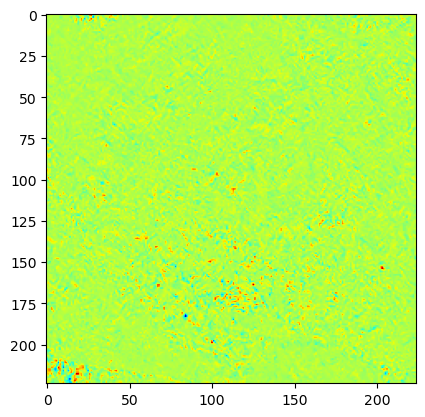

In [171]:
plt.imshow(attribution, cmap='jet')

In [172]:
224/7

32.0

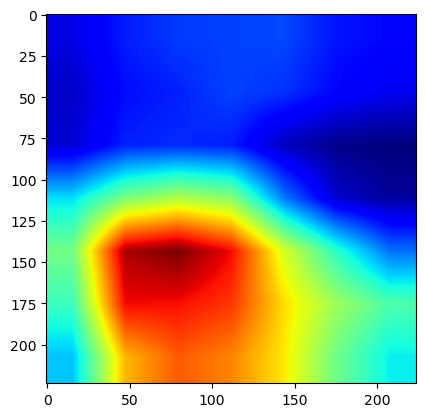

In [159]:
from pytorch_grad_cam import run_dff_on_image, GradCAM, FullGrad, LayerCAM, GradCAMPlusPlus, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
cam = LayerCAM(model=me.model, target_layers=[me.get_cam_target_layer()])
cinp = inp.clone().detach()
cinp.requires_grad_(True)
sal = cam(input_tensor=cinp, targets=[ClassifierOutputTarget(topidx)])
plt.imshow(sal[0], cmap='jet')

In [153]:
%run src/metrics
import torch
sal=res["CPE_64_500_ipw_0.1"][0]
sal.shape
metrics = Metrics()
mmm = metrics.get_metrics(me.model, inp, torch.stack([sal,sal]), image_info, nsteps=100)
mmm
#metrics.generate(me.model, inp, sal, topidx, is_neg=False, nsteps=224)
#metrics.generate(me.model, inp, sal, topidx, is_neg=True, nsteps=224)

4.499999992549419 4.133682798032142
42.49999672174454 30.422940058807125


{'pred_pos_auc': 4.499999992549419,
 'pred_neg_auc': 42.49999672174454,
 'pred_del_auc': 4.133682798032142,
 'pred_ins_auc': 30.422940058807125,
 'pred_adp': 33.91691970825195,
 'pred_pic': 0.0,
 'target_pos_auc': 4.499999992549419,
 'target_neg_auc': 42.49999672174454,
 'target_del_auc': 4.133682798032142,
 'target_ins_auc': 30.422940058807125,
 'target_adp': 33.91691970825195,
 'target_pic': 0.0}

In [113]:
#ppp
%run src/benchmark
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(format='[%(asctime)-15s  %(filename)s:%(lineno)d - %(process)d] %(message)s', level=logging.DEBUG)

scores_dict = get_sal_scores(me, inp, dict(aaa=sal.unsqueeze(0)))


[2024-09-13 22:41:58,601  benchmark.py:236 - 15524] scores  0, aaa, 0.04129524061400005, 0.6960386133889968


In [ ]:
auc_score = auc(steps, values) * 100

In [103]:
ttt= torch.maximum(torch.rand(3), torch.rand(3))

In [111]:
ttt.max(0, keepdim=True)

torch.return_types.max(
values=tensor([0.7853]),
indices=tensor([2]))

[2024-09-09 21:34:49,091  cpe.py:345] RelIpwGen 64
[2024-09-09 21:34:49,091  cpe.py:224] IpSalCreator: nmasks=500; added = 500
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]
[2024-09-09 21:34:53,591  cpe.py:383] number of batches: 16
[2024-09-09 21:34:54,166  cpe.py:224] IpSalCreator: nmasks=1000; added = 500
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]
[2024-09-09 21:34:58,268  cpe.py:383] number of batches: 32
[2024-09-09 21:34:59,486  cpe.py:224] IpSalCreator: nmasks=2000; added = 1000
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.52it/s]
[2024-09-09 21:35:07,712  cpe.py:383] number of batches: 64
[2024-09-09 21:35:10,108  cpe.py:224] IpSalCreator: nmasks=4000; added = 2000
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:0

[2024-09-09 21:35:33,703  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Users\\zivhd\\anaconda3\\envs\\mcmc\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:33,704  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Users\\zivhd\\anaconda3\\envs\\mcmc\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:33,706  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Users\\zivhd\\anaconda3\\envs\\mcmc\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:33,706  font_manager.py:1391] findfont: score(FontEnt

[2024-09-09 21:35:33,738  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITEDI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
[2024-09-09 21:35:33,738  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebuc.ttf', name='Trebuchet MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:33,746  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAX.TTF', name='Lucida Fax', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:33,747  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GAHROM.TTF', name='Guttman Aharoni', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:33,748  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Font

[2024-09-09 21:35:33,790  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbell.ttf', name='Corbel', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
[2024-09-09 21:35:33,791  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\davidbd.ttf', name='David', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:33,792  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HTOWERTI.TTF', name='High Tower Text', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:33,793  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\javatext.ttf', name='Javanese Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:33,793  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\

[2024-09-09 21:35:33,841  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothB.ttc', name='Yu Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:33,841  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 11.0975
[2024-09-09 21:35:33,847  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALIFI.TTF', name='Californian FB', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:33,848  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERTILI.TTF', name='Perpetua Titling MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
[2024-09-09 21:35:33,848  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windo

[2024-09-09 21:35:33,896  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\WINGDNG3.TTF', name='Wingdings 3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:33,896  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:33,896  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MUDIR.TTF', name='Mudir MT', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
[2024-09-09 21:35:33,896  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OCRAEXT.TTF', name='OCR A Extended', style='normal', variant='normal', weight=400, stretch='expanded', size='scalable')) = 10.25
[2024-09-09 21:35:33,901  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fo

[2024-09-09 21:35:33,936  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GARA.TTF', name='Garamond', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:33,936  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HARLOWSI.TTF', name='Harlow Solid Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:33,946  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\RAVIE.TTF', name='Ravie', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:33,946  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARBSQDTP.TTF', name='AGA Arabesque Desktop', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:33,946  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\

[2024-09-09 21:35:33,996  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_I.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:33,996  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HADASAHB.TTF', name='Hadassah Friedlaender', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:33,996  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MANTDEC.TTF', name='Guttman Mantova-Decor', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:33,996  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SPINDOUT.TTF', name='Simple Indust Outline', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:33,996  font_manager.py:1391] findfont: score(FontEnt

[2024-09-09 21:35:34,036  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 7.8986363636363635
[2024-09-09 21:35:34,036  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
[2024-09-09 21:35:34,036  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\STAM.TTF', name='Guttman Stam', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,036  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKBI.TTF', name='Rockwell', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2024-09-09 21:35:34,041  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WIND

[2024-09-09 21:35:34,076  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\courbd.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:34,076  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GLSNECB.TTF', name='Gill Sans MT Ext Condensed Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
[2024-09-09 21:35:34,079  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelb.ttf', name='Corbel', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:34,080  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DROGM.TTF', name='Guttman Drogolin', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,080  font_manager.py:1391] findfont: score(FontEntry(fnam

[2024-09-09 21:35:34,116  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HATTEN.TTF', name='Haettenschweiler', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,116  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STENCIL.TTF', name='Stencil', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,116  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\symbol.ttf', name='Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,116  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguiemj.ttf', name='Segoe UI Emoji', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,116  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\A

[2024-09-09 21:35:34,150  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENTAUR.TTF', name='Centaur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,150  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOS.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
[2024-09-09 21:35:34,150  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:34,150  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKEB.TTF', name='Rockwell Extra Bold', style='normal', variant='normal', weight=800, stretch='normal', size='scalable')) = 10.43
[2024-09-09 21:35:34,150  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\W

[2024-09-09 21:35:34,195  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeprb.ttf', name='Segoe Print', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:34,196  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candara.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,196  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALISTB.TTF', name='Calisto MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:34,196  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\AGENCYB.TTF', name='Agency FB', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:34,196  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GA

[2024-09-09 21:35:34,229  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSAN.TTF', name='MS Reference Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,229  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITEI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:34,229  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaVF-Italic.ttf', name='Sitka', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:34,229  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,229  font_manager.py:1391] findfont: score(FontEntry(fname=

[2024-09-09 21:35:34,266  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2024-09-09 21:35:34,266  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\l_10646.ttf', name='Lucida Sans Unicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,271  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GARABD.TTF', name='Garamond', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:34,271  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\RAGE.TTF', name='Rage Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:34,271  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\

[2024-09-09 21:35:34,313  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GFRANK.TTF', name='Guttman Frank', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,316  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALIFR.TTF', name='Californian FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,316  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\palai.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:34,316  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BERNHC.TTF', name='Bernard MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
[2024-09-09 21:35:34,316  font_manager.py:1391] findfont: score(FontEntry(fname='C

[2024-09-09 21:35:34,349  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LSANS.TTF', name='Lucida Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,350  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuil.ttf', name='Segoe UI', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
[2024-09-09 21:35:34,350  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
[2024-09-09 21:35:34,350  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\gishabd.ttf', name='Gisha', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:34,350  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GIL_____.

[2024-09-09 21:35:34,386  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GMYAMFIX.TTF', name='Guttman Myamfix', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,391  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaVF-Italic.ttf', name='Sitka', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:34,391  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MIRFX.TTF', name='Guttman-CourMir', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,391  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothL.ttc', name='Yu Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
[2024-09-09 21:35:34,391  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\

[2024-09-09 21:35:34,431  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BROADW.TTF', name='Broadway', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,431  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DIWANBNT.TTF', name='Diwani Bent', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,436  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,436  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:34,436  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windo

[2024-09-09 21:35:34,466  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\POORICH.TTF', name='Poor Richard', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,466  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HTOWERTI.TTF', name='High Tower Text', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:34,476  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITED.TTF', name='Lucida Bright', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
[2024-09-09 21:35:34,479  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SPOUTPAT.TTF', name='Simple Outline Pat', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,480  font_manager.py:1391] findfont: score(FontEntry(fname='C:\

[2024-09-09 21:35:34,516  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\lucon.ttf', name='Lucida Console', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,516  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LCALLIG.TTF', name='Lucida Calligraphy', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:34,516  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCKB.TTF', name='Rockwell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2024-09-09 21:35:34,516  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VINERITC.TTF', name='Viner Hand ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,516  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows

[2024-09-09 21:35:34,566  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TZVIM.TTF', name='Guttman Hatzvi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,566  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ALGER.TTF', name='Algerian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,566  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\symbol.ttf', name='Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,566  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\OLDANBLD.TTF', name='Old Antic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,566  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ntail

[2024-09-09 21:35:34,606  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASBD.TTF', name='Eras Bold ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,606  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMCN.TTF', name='Franklin Gothic Demi Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
[2024-09-09 21:35:34,612  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,613  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_R.TTF', name='Bodoni MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,616  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WIND

[2024-09-09 21:35:34,650  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GKAVMED.TTF', name='Guttman Kav', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,650  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\rod.ttf', name='Rod', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,650  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STAM1.TTF', name='Guttman Stam1', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,650  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LTYPEB.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
[2024-09-09 21:35:34,650  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\c

[2024-09-09 21:35:34,686  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeui.ttf', name='Segoe UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,691  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GKAVLIT.TTF', name='Guttman Kav-Light', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2024-09-09 21:35:34,691  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSB.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
[2024-09-09 21:35:34,691  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2024-09-09 21:35:34,696  font_manager.py:1391] findfont: score(FontEntry(fname='C:\\WIN

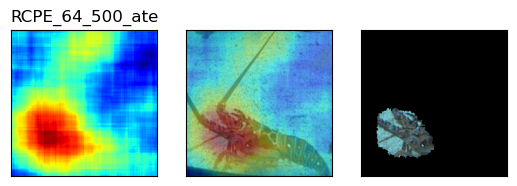

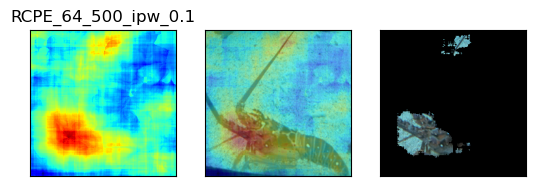

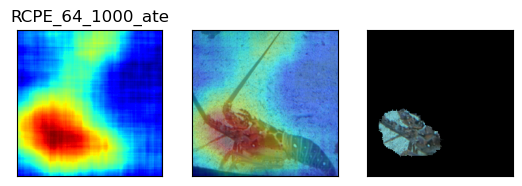

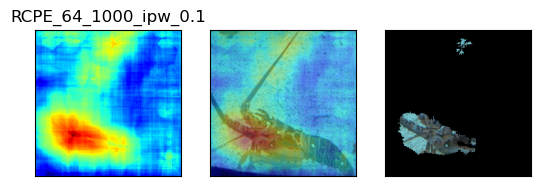

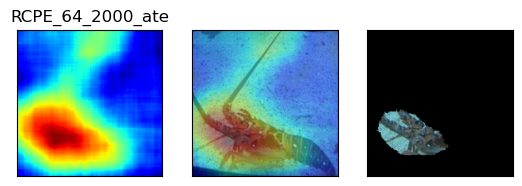

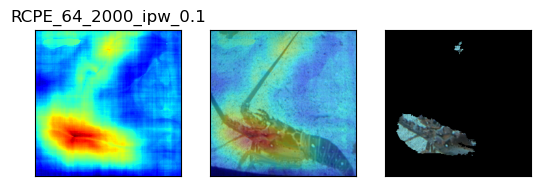

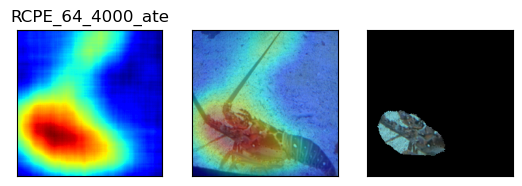

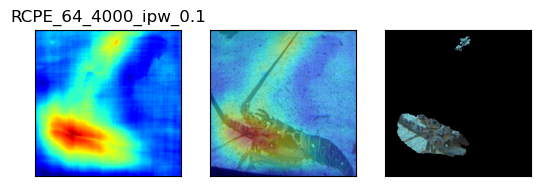

In [6]:
%run src/intutils
%run src/cpe
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(format='[%(asctime)-15s  %(filename)s:%(lineno)d] %(message)s', level=logging.DEBUG)

segsize=64
algo = IpwSalCreator(f"RCPE_{segsize}", [500,1000,2000,4000], ipwg=RelIpwGen, segsize=segsize, batch_size=32)
res = algo(me, inp, topidx)
show_sal_dict(res, img)
sals_dict.update(res)


In [7]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(format='[%(asctime)-15s  %(filename)s:%(lineno)d - %(process)d] %(message)s', level=logging.DEBUG)
logging.info("hi")
#logging.basicConfig(level=logging.INFO,
#                    format='%(asctime)s - %(levelname)s - %(message)s',
#                    handlers=[logging.StreamHandler()])

# Create a logger object
#logger = logging.getLogger()
#logger.info("ooohi")

[2024-09-09 21:35:41,281  453820311.py:4 - 6380] hi


In [8]:
scores_dict = get_sal_scores(me, inp, sals_dict)

[2024-09-09 21:35:49,692  benchmark.py:209 - 6380] scores  0, RCPE_64_500_ate, 0.05187990299961591, 0.741999012821907
[2024-09-09 21:35:56,688  benchmark.py:209 - 6380] scores  0, RCPE_64_500_ipw_0.1, 0.05729123176181959, 0.693431108306478
[2024-09-09 21:36:03,763  benchmark.py:209 - 6380] scores  0, RCPE_64_1000_ate, 0.05239184522180069, 0.7186698957739281
[2024-09-09 21:36:11,091  benchmark.py:209 - 6380] scores  0, RCPE_64_1000_ipw_0.1, 0.05397659825890155, 0.7091900806798159
[2024-09-09 21:36:18,646  benchmark.py:209 - 6380] scores  0, RCPE_64_2000_ate, 0.051728192369957834, 0.7187559620090594
[2024-09-09 21:36:26,241  benchmark.py:209 - 6380] scores  0, RCPE_64_2000_ipw_0.1, 0.046703114150583334, 0.7437755578835744
[2024-09-09 21:36:33,746  benchmark.py:209 - 6380] scores  0, RCPE_64_4000_ate, 0.05020260221121475, 0.6971030249447462
[2024-09-09 21:36:41,226  benchmark.py:209 - 6380] scores  0, RCPE_64_4000_ipw_0.1, 0.048959283533012835, 0.725349053980608


In [463]:

%run src/cpe

simp = SimpGen(64, collect_masks=True)
simp.gen(me.narrow_model(topidx), inp, 2000)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.46it/s]


In [464]:
sal = simp.get_ate_sal()
sal.shape

torch.Size([1, 224, 224])

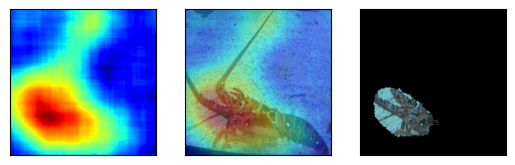

In [465]:
showsal(sal[0].cpu(), img)

In [466]:
## Prewitt Sobel and Scharr gradient 5x5 convolution matrices
## Expansion and implementation of a 3x3 soble
def gsobel(K):    
    arng = torch.arange(K, dtype=torch.float32)
    offs = arng-arng.mean()
    dist = offs.abs()    
    return torch.nan_to_num(offs / (dist.unsqueeze(0)**2 +  dist.unsqueeze(1)**2),0)


sobel_size=63
ndist = 31

sblx = gsobel(sobel_size)
#sblx = gsobel(5)
sbly = sblx.transpose(0,1)
#sblx

In [467]:
all_masks = torch.concat(simp.all_masks)

all_masks.shape


torch.Size([2000, 224, 224])

In [468]:
import torch.nn.functional as F
isal = sal.cpu()
print(isal.shape)
ctx = F.conv2d(isal.unsqueeze(0), sblx.unsqueeze(0).unsqueeze(0), padding="same")[0,0]
cty = F.conv2d(isal.unsqueeze(0), sbly.unsqueeze(0).unsqueeze(0), padding="same")[0,0]

torch.Size([1, 224, 224])


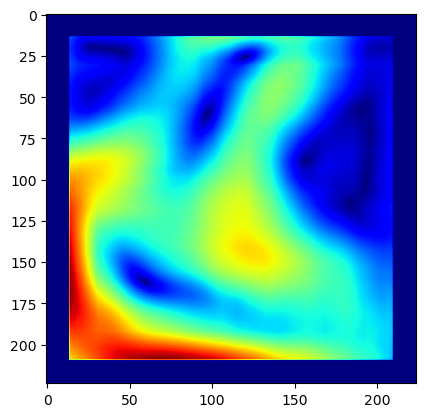

In [469]:
grad = (ctx**2 + cty**2).sqrt()
pad = 14
zzz = torch.zeros(grad.shape)
zzz[ pad:-pad, pad:-pad]=grad[ pad:-pad, pad:-pad]
plt.imshow(zzz, cmap="jet")
#plt.imshow(isal[0], cmap="jet", alpha=0.6)

In [470]:
csz = (ctx**2 + cty**2).sqrt()
cszbar = torch.quantile(csz, 0.01)
#torch.quantile(csz, 0.6)
dist = ndist
offsx = (ctx*dist/csz).to(torch.int32)
offsy = (cty*dist/csz).to(torch.int32)
#offsx[175,25]


In [471]:
H, W = 224,224
idxx = offsx + torch.arange(W).unsqueeze(0)
idxy = offsy + torch.arange(H).unsqueeze(1)
isok = ((csz > cszbar) & (idxx >= 0) & (idxx < W) & (idxy >= 0) & (idxy < H))
isok.sum() / (H*W)

tensor(0.9869)

In [472]:
msk = all_masks[1]
bmasks = all_masks[0:32]
msk.shape

torch.Size([224, 224])

In [473]:
torch.minimum(torch.arange(10), torch.tensor([8]))

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 8])

In [474]:
confidx = torch.maximum(torch.minimum(idxx.flatten()+idxy.flatten()*W, torch.tensor(H*W-1)), torch.tensor([0]))

mvals = msk.flatten().gather(0, confidx).reshape(msk.shape)

In [475]:
confs = []
svals = []
##############
for ndist in range(20,44):
    offsx = (ctx*ndist/csz).to(torch.int32)
    offsy = (cty*ndist/csz).to(torch.int32)
    H, W = 224,224
    idxx = offsx + torch.arange(W).unsqueeze(0)
    idxy = offsy + torch.arange(H).unsqueeze(1)
    isok = ((csz > cszbar) & (idxx >= 0) & (idxx < W) & (idxy >= 0) & (idxy < H))
    confidx = torch.maximum(torch.minimum(idxx.flatten()+idxy.flatten()*W, torch.tensor(H*W-1)), torch.tensor([0]))
    confs.append(confidx)
    #print(isal.shape)
    svals.append(isal.flatten().gather(0, confidx))
    
##########
svals = torch.stack(svals)
confs = torch.stack(confs)

In [476]:
maxsal = svals.max(dim=0)
#confs.shape
selected = torch.arange(confs.shape[1]) + maxsal.indices * confs.shape[1]
confidx = confs.flatten().gather(0,selected)
confidx

tensor([ 4276,  4275,  4274,  ..., 43424, 43424, 44097])

In [477]:
gidx = ((torch.arange(bmasks.shape[0]) * confidx.numel()).unsqueeze(1) + confidx.unsqueeze(0)).flatten()
ref = bmasks.flatten().gather(0, gidx).reshape(bmasks.shape)
print(ref.shape)


torch.Size([32, 224, 224])


In [478]:
if False:
    roffs = torch.stack((idxy, idxx), dim=2)
    paint = roffs[highlight]
    print(paint)
    vvv = mmm
    vvv=torch.zeros(vvv.shape)
    for py, px in paint:
        vvv[py,px]=200
    #vvv=vvv.scatter(0, paint, 200)
    showsal(vvv,img)

torch.Size([224, 224])


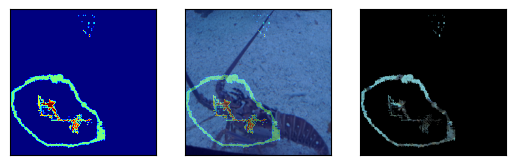

In [480]:
mmm = torch.zeros(isal[0].shape)
highlight = (isal[0] >= 2) & (isal[0] <= 2.2)
mmm[highlight] = 100
#vvv=torch.zeros(mmm.shape).flatten()
vvv = mmm.flatten()
parts = confidx[vvv==100]
#vvv=torch.zeros(mmm.shape).flatten()
#print(len(parts))
#print(parts)
vvv=vvv.scatter(0, parts, 200*torch.ones(vvv.shape))
vvv =vvv.reshape(mmm.shape)
print(vvv.shape)
showsal(vvv,img)

In [481]:
if False:
    ooo = torch.arange(12).reshape(3,2,2)

    print(ooo)

    xi = torch.tensor([[0,0],[1,1]])
    yi = torch.tensor([[0,0],[0,1]])

    pos = yi.flatten()*2 + xi.flatten()
    print(pos)

    gidx = ((torch.arange(ooo.shape[0]) * pos.numel()).unsqueeze(1) + pos.unsqueeze(0)).flatten()
    print(gidx)
    ref = ooo.flatten().gather(0,gidx).reshape(ooo.shape)
    ref

    #ooo.flatten(1).gather(1, ppp.unsqueeze(0)).reshape(ooo.shape)

In [482]:
#mbin 

icats = torch.arange(4).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
gidx = None
prev_bmask_shape = None
s_saliency = None
s_weights = None

for idx, bmasks in enumerate(simp.all_masks):
    
    if bmasks.shape != prev_bmask_shape:
        gidx = ((torch.arange(bmasks.shape[0]) * confidx.numel()).unsqueeze(1) + confidx.unsqueeze(0)).flatten()
        prev_bmask_shape = bmasks.shape
        
    ref = bmasks.flatten().gather(0, gidx).reshape(bmasks.shape)
    mout = simp.all_pred[idx]
    #print(mout)
    #print(bmasks.shape)
    ref = bmasks.flatten().gather(0, gidx).reshape(bmasks.shape)
    cat = ((bmasks > 0.5) * 1 + (ref > 0.5) * 2).unsqueeze(0)
    
    mbin = (icats == cat)
    #print(cat.shape, mout.shape, mbin.shape)
    saliency = (mout.squeeze(1).unsqueeze(0) * mbin).sum(dim=1)
    #print(mbin.shape)
    weights = mbin.sum(dim=1)    
    if s_saliency is None:
        s_saliency = saliency
        s_weights = weights
    else:
        s_saliency += saliency
        s_weights += weights
    #break    
    #print(mbin.shape)
    #break
    
s_saliency.shape, s_weights.shape

(torch.Size([4, 224, 224]), torch.Size([4, 224, 224]))

In [483]:
cidx = torch.arange(4)
treatment_sal = s_saliency[(cidx & 1) == 1]
control_sal = s_saliency[(cidx & 1) == 0]
p_treatment_weights = s_weights[(cidx & 1) == 1]
p_control_weights = s_weights[(cidx & 1) == 0]

clip = 0.1
t_clipping = torch.tensor([clip])    
c_clipping = torch.tensor([clip])    

treatment_prob =  torch.max(p_treatment_weights / (p_treatment_weights + p_control_weights + 1), t_clipping)
control_prob =  torch.max(p_control_weights / (p_treatment_weights + p_control_weights + 1), c_clipping)

ipw = (
    ((treatment_sal / treatment_prob).sum(dim=0) / (p_treatment_weights / treatment_prob).sum(dim=0)) -
    ((control_sal / control_prob).sum(dim=0) / (p_control_weights / control_prob).sum(dim=0)) ).unsqueeze(0)            

ipw.shape
#treatment_prob.shape, p_treatment_weights.shape, p_control_weights.shape, t_clipping.shape

torch.Size([1, 224, 224])

In [484]:
cate = (s_saliency[(cidx & 1) == 1].sum(dim=0) / s_weights[(cidx & 1) == 1].sum(dim=0)) - (s_saliency[(cidx & 1) == 0].sum(dim=0)/s_weights[(cidx & 1) == 0].sum(dim=0))
ipw.shape, isal.shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

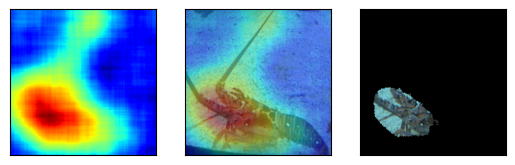

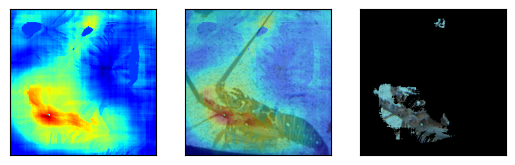

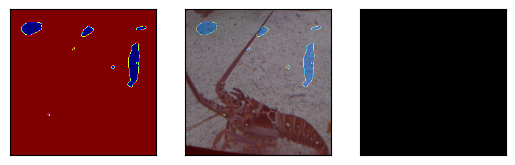

In [485]:
fsal = isal * (~isok) + ipw * (isok)
fsal =  ipw * (isok)

showsal(cate, img)
showsal(fsal[0], img)
showsal(isok*1.0, img)


In [486]:
import logging

logging.basicConfig(format='[%(asctime)-15s  %(filename)s:%(lineno)d - %(process)d] %(message)s', level=logging.DEBUG)

xsals_dict = dict(ipw=fsal, ate=isal)
scores_dict = get_sal_scores(me, inp, xsals_dict)


[2024-09-10 07:14:39,484  benchmark.py:209 - 6380] scores  0, ipw, 0.03332671925058227, 0.6918003910790763
[2024-09-10 07:14:47,031  benchmark.py:209 - 6380] scores  0, ate, 0.05364089633733389, 0.7056561681685187


In [487]:
for key, stats in scores_dict.items():
    print(key, stats["del_auc"], stats["ins_auc"]), 
    

ipw 0.03332671925058227 0.6918003910790763
ate 0.05364089633733389 0.7056561681685187


In [385]:
#run src/adaptors
#import pytorch_grad_cam 
#dir(pytorch_grad_cam)

ddd = [1,2,3]
import random
random.shuffle(ddd)
ddd

[1, 3, 2]

In [185]:
iii = torch.arange(6). reshape((2,3))
iii[:,(1,1)]

tensor([[1, 1],
        [4, 4]])

In [770]:
ee= 1000
f"{ee:x}"

'3e8'

In [183]:
import re
def create_xxx_sals(me, images):
    pass
def create_yyy_sals(me, images):
    pass
ptrn = re.compile("create_(.*)_sals")

def ggg():
    return [rrr.group(1) for rrr in [ptrn.match(x) for x in globals()] if rrr is not None]
ggg()

['xxx', 'yyy']